In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

df = pd.read_csv('king_rook_vs_king.csv')

In [3]:
depth_map = {
    "draw": 0,
    "zero": 1, "one": 1, "two": 1, "three": 1, "four": 1,
    "five": 2, "six": 2, "seven": 2, "eight": 2,
    "nine": 3, "ten": 3, "eleven": 3, "twelve": 3,
    "thirteen": 4, "fourteen": 4, "fifteen": 4, "sixteen": 4
}

df["win_depth"] = df["white_depth_of_win"].map(depth_map)
df.drop(columns=["white_depth_of_win"], inplace=True)

letter_to_num = {'a': 1, 'b': 2, 'c': 3, 'd': 4,
                 'e': 5, 'f': 6, 'g': 7, 'h': 8}

# Mapping coordinate letters into integers
for col in ['white_king_file', 'white_rook_file', 'black_king_file']:
    df[col] = df[col].map(letter_to_num)


# Manhattan distance of white king and black king
df['distance_wk_bk'] = (
    abs(df['white_king_file'] - df['black_king_file']) +
    abs(df['white_king_rank'] - df['black_king_rank'])
)

# Manhattan distance of white rook and black king
df['distance_wr_bk'] = (
    abs(df['white_rook_file'] - df['black_king_file']) +
    abs(df['white_rook_rank'] - df['black_king_rank'])
)

# Manhattan distance of white king and white rook
df['distance_wk_wr'] = (
    abs(df['white_king_file'] - df['white_rook_file']) +
    abs(df['white_king_rank'] - df['white_rook_rank'])
)

# Manhattan distance of black king to nearest edge
df['distance_bk_edge'] = df.apply(
    lambda row: min(
        abs(row['black_king_file'] - 1),
        abs(row['black_king_file'] - 8),
        abs(row['black_king_rank'] - 1),
        abs(row['black_king_rank'] - 8)
    ), axis=1
)

# (bool) is rook unprotected and under attack
def unprotected_rook(row):
    bk_attacks_wr = max(abs(row['black_king_file'] - row['white_rook_file']),
                        abs(row['black_king_rank'] - row['white_rook_rank'])) == 1
    
    wk_protects_wr = max(abs(row['white_king_file'] - row['white_rook_file']),
                         abs(row['white_king_rank'] - row['white_rook_rank'])) == 1
    
    return int(bk_attacks_wr and not wk_protects_wr)
df['rook_unprotected_and_attacked'] = df.apply(unprotected_rook, axis=1)

In [4]:
X = df.drop(columns=["win_depth"])
y = df["win_depth"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=10,
    num_leaves=32,
    learning_rate=0.2,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 22444, number of used features: 11
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [5]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       559
           1       0.96      0.95      0.96       126
           2       0.95      0.96      0.96       636
           3       0.97      0.97      0.97      2030
           4       0.98      0.98      0.98      2261

    accuracy                           0.98      5612
   macro avg       0.97      0.97      0.97      5612
weighted avg       0.98      0.98      0.98      5612



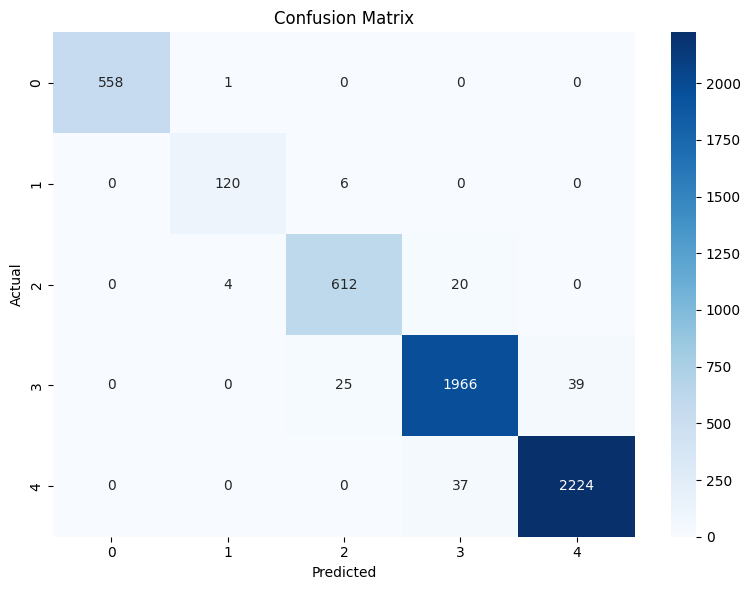

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 22444, number of used features: 11
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [6]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 5-fold stratifed cross-validated macro f1 average (might be overkill)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')
print("All scores:", cv_scores)
print("Mean:", np.mean(cv_scores))
print("Std:", np.std(cv_scores))